# 1. Introduction

A Newspaper Publishing Company (NPC) is facing increasing churn rates since years. This evolution has been jumpstarted by the rise of news- websites, and has continued at an accelerating rate due to the popularity of tablet computers and (social) news- aggregator applications.

Hence the NPC requires a predictive retention (or churn) model in order to predict which customers will not renew their newspaper subscriptionss. Customers are not allowed to cancel their subscriptions;hence a customer is defined as  a  churner  if  he  or  she  does  not  renew  the  subscription  once  the  current subscriptions end.

**Submitted By :**
**_Shriya Jain_**

# 2. Data Prepration

## 2.1 Import libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


## 2.2 Load Data

In [2]:
customers_df = pd.read_csv('2 - NPC Retention Data/customers.txt',sep=';')
credit_df = pd.read_csv('2 - NPC Retention Data/credit.txt',sep=';')
delivery_df = pd.read_csv('2 - NPC Retention Data/delivery.txt',sep=';')
formula_df = pd.read_csv('2 - NPC Retention Data/formula.txt',sep=';')
credit_df = pd.read_csv('2 - NPC Retention Data/credit.txt',sep=';')
complaints_df = pd.read_csv('2 - NPC Retention Data/complaints.txt',sep=';')


In [3]:
subscriptions_df = pd.read_csv('2 - NPC Retention Data/subscriptions.txt',delim_whitespace=True)
pd.options.display.max_columns = None
subscriptions_df.head(3)

,SubscriptionID,CustomerID,ProductID,Pattern,StartDate,EndDate,NbrNewspapers,NbrStart,RenewalDate,PaymentType,PaymentStatus,PaymentDate,FormulaID,GrossFormulaPrice,NetFormulaPrice,NetNewspaperPrice,ProductDiscount,FormulaDiscount,TotalDiscount,TotalPrice,TotalCredit
1000024,1150045,8.0,1111110.0,=VLOOKUP(D2;$E$15462:$F$15473;2;0),18/01/2010,17/04/2010,76,25,17/03/2010,BT,Paid,27/01/2010,8552,79,79,1.039.474,0,0,0,79,0.0
1000082,1150046,8.0,1111110.0,14/01/2010,12/03/2010,50,25,3/03/2010,BT,Paid,11/02/2010,10017,519.737,29.6,0.592,0,223.737,223.737,29.6,0,NaN
100012,89085,8.0,1111110.0,1/01/2008,30/12/2008,304,10,21/11/2008,BT,Paid,12/12/2007,875,249,249,0.811842,0,0,0,246.8,-2.2,NaN


In [4]:
# Removing vlookup entry

for col in range(3,len(subscriptions_df.columns)-1):
    subscriptions_df.iloc[0,col]=subscriptions_df.iloc[0,col+1]
    
subscriptions_df.head(2)
subscriptions_df.isna().sum()

,SubscriptionID,CustomerID,ProductID,Pattern,StartDate,EndDate,NbrNewspapers,NbrStart,RenewalDate,PaymentType,PaymentStatus,PaymentDate,FormulaID,GrossFormulaPrice,NetFormulaPrice,NetNewspaperPrice,ProductDiscount,FormulaDiscount,TotalDiscount,TotalPrice,TotalCredit
1000024,1150045,8.0,1111110.0,18/01/2010,17/04/2010,76,25,17/03/2010,BT,Paid,27/01/2010,8552,79,79,1.039.474,0,0,0,79,0,0.0
1000082,1150046,8.0,1111110.0,14/01/2010,12/03/2010,50,25,3/03/2010,BT,Paid,11/02/2010,10017,519.737,29.6,0.592,0,223.737,223.737,29.6,0,NaN


SubscriptionID           0
CustomerID              12
ProductID               12
Pattern                 12
StartDate               12
EndDate                 12
NbrNewspapers           12
NbrStart                12
RenewalDate             12
PaymentType             12
PaymentStatus           18
PaymentDate            333
FormulaID              333
GrossFormulaPrice      333
NetFormulaPrice        333
NetNewspaperPrice      333
ProductDiscount        333
FormulaDiscount        333
TotalDiscount          333
TotalPrice            4876
TotalCredit          15470
dtype: int64

In [5]:
# moving index to subscriptions id and resetting index
subs_cols = subscriptions_df.columns
subscriptions_df = subscriptions_df.drop('TotalCredit',axis=1)
subscriptions_df.reset_index(inplace=True)
subscriptions_df.columns = subs_cols
subscriptions_df.head(2)
subscriptions_df.isna().sum()

,SubscriptionID,CustomerID,ProductID,Pattern,StartDate,EndDate,NbrNewspapers,NbrStart,RenewalDate,PaymentType,PaymentStatus,PaymentDate,FormulaID,GrossFormulaPrice,NetFormulaPrice,NetNewspaperPrice,ProductDiscount,FormulaDiscount,TotalDiscount,TotalPrice,TotalCredit
0,1000024,1150045,8.0,1111110.0,18/01/2010,17/04/2010,76,25,17/03/2010,BT,Paid,27/01/2010,8552,79,79,1.039.474,0,0,0,79,0
1,1000082,1150046,8.0,1111110.0,14/01/2010,12/03/2010,50,25,3/03/2010,BT,Paid,11/02/2010,10017,519.737,29.6,0.592,0,223.737,223.737,29.6,0


SubscriptionID          0
CustomerID              0
ProductID              12
Pattern                12
StartDate              12
EndDate                12
NbrNewspapers          12
NbrStart               12
RenewalDate            12
PaymentType            12
PaymentStatus          12
PaymentDate            18
FormulaID             333
GrossFormulaPrice     333
NetFormulaPrice       333
NetNewspaperPrice     333
ProductDiscount       333
FormulaDiscount       333
TotalDiscount         333
TotalPrice            333
TotalCredit          4876
dtype: int64

In [6]:
# Formatting data as some of the column data is not aligned due to blank values
for row in range(len(subscriptions_df)):
    if (subscriptions_df.iloc[row,7]=='BT'):
        for col in range(len(subscriptions_df.columns)-3,6,-1):
            subscriptions_df.iloc[row,col+2]=subscriptions_df.iloc[row,col]
        subscriptions_df.iloc[row,7]=np.nan
        subscriptions_df.iloc[row,8]=np.nan
    if (subscriptions_df.iloc[row,8]=='BT' or subscriptions_df.iloc[row,8]=='DD'):
        for col in range(len(subscriptions_df.columns)-2,7,-1):
            subscriptions_df.iloc[row,col+1]=subscriptions_df.iloc[row,col]
        subscriptions_df.iloc[row,8]=np.nan
    if (subscriptions_df.iloc[row,10]=='Not'):
        subscriptions_df.iloc[row,10]='Not Paid'
        subscriptions_df.iloc[row,11]=np.nan
    x=str(subscriptions_df.iloc[row,7])
    if (x.rfind('/')!=-1):
        subscriptions_df.iloc[row,8]=subscriptions_df.iloc[row,7]
        subscriptions_df.iloc[row,7]=np.nan
    x=str(subscriptions_df.iloc[row,12])
    if (x.rfind('/')!=-1):
        subscriptions_df.iloc[row,12]='99999999'
        
    if('float' not in str(type(subscriptions_df.loc[row,'NetNewspaperPrice']))):
        x=str(subscriptions_df.loc[row,'NetNewspaperPrice'])
        if ((subscriptions_df.loc[row,'NetNewspaperPrice'].count('.')>1)|(x.rfind('-')!=-1)):
            subscriptions_df.loc[row,'NetNewspaperPrice']=np.nan
    
    cols = ['GrossFormulaPrice','NetFormulaPrice','NetNewspaperPrice','ProductDiscount','FormulaDiscount','TotalDiscount','TotalPrice','TotalCredit']
    for col in cols:
        if('float' not in str(type(subscriptions_df.loc[row,col]))):
            if (subscriptions_df.loc[row,col].count('.')>1):
                subscriptions_df.loc[row,col]=np.nan
subscriptions_df.isna().sum()


SubscriptionID          0
CustomerID              0
ProductID              12
Pattern                12
StartDate              12
EndDate                12
NbrNewspapers          12
NbrStart               57
RenewalDate          4837
PaymentType            12
PaymentStatus          12
PaymentDate           845
FormulaID              12
GrossFormulaPrice    1012
NetFormulaPrice       334
NetNewspaperPrice    2117
ProductDiscount       351
FormulaDiscount       986
TotalDiscount        1004
TotalPrice            333
TotalCredit           341
dtype: int64

In [7]:
# type casting columns to float as this would return error if it has any invalid values
cols=['NetNewspaperPrice','FormulaDiscount','TotalDiscount','ProductDiscount','TotalCredit']
for col in cols:
    subscriptions_df[col]=subscriptions_df[col].astype(float)

subscriptions_df[subscriptions_df['ProductID'].isna()].index

Int64Index([15459, 15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467,
            15468, 15469, 15470],
           dtype='int64')

In [8]:
# dropping rows which don't have product ID
subscriptions_df = subscriptions_df.drop(subscriptions_df.index[15459:15471])

In [9]:
# type casting column to int as this would return error if it has any invalid values
subscriptions_df.FormulaID=subscriptions_df.FormulaID.astype(int) 

# filling null values with some really high valid value
subscriptions_df.RenewalDate=np.where(subscriptions_df.RenewalDate.isna()==True,'01/01/2099',subscriptions_df.RenewalDate)
subscriptions_df.PaymentDate=np.where(subscriptions_df.PaymentDate.isna()==True,'01/01/2099',subscriptions_df.PaymentDate)

# type casting columns to date as this would return error if it has any invalid values
cols=['StartDate','EndDate','RenewalDate','PaymentDate']
for col in cols:
    subscriptions_df[col]=pd.to_datetime(subscriptions_df[col],format='%d/%m/%Y')


In [10]:
# Other tables and thier datetime columns
delivery_df.StartDate=pd.to_datetime(delivery_df.StartDate,format='%d/%m/%Y')        
delivery_df.EndDate=pd.to_datetime(delivery_df.EndDate,format='%d/%m/%Y')    
customers_df.DOB=pd.to_datetime(customers_df.DOB,format='%d/%m/%Y')


# Merging all the tables based on unique keys
merged_df=pd.merge(subscriptions_df,formula_df,how='left',on='FormulaID')
merged_df=pd.merge(delivery_df,merged_df,how='left',on='SubscriptionID')
merged_df=pd.merge(merged_df,customers_df,how='left',on='CustomerID')
merged_df=pd.merge(merged_df,credit_df,how='left',on='SubscriptionID')
merged_df=pd.merge(merged_df,complaints_df,how='left',on=['CustomerID','ProductID'])

In [11]:
# Calculating percent of null values in each column
(merged_df.isna().sum().sort_values()/merged_df.shape[0])*100

SubscriptionID        0.000000
DOB                   0.000000
FormulaID             0.000000
PaymentDate           0.000000
PaymentStatus         0.000000
PaymentType           0.000000
RenewalDate           0.000000
District              0.000000
NbrNewspapers_x       0.000000
EndDate_y             0.000000
Pattern               0.000000
ProductID             0.000000
CustomerID            0.000000
EndDate_x             0.000000
StartDate_x           0.000000
ZIP                   0.000000
StreeID               0.000000
DeliveryType          0.000000
StartDate_y           0.000000
TotalPrice            0.000000
NetFormulaPrice       0.004812
TotalCredit           0.054536
ProductDiscount       0.068972
NbrStart              0.187668
Gender                3.025151
FormulaDiscount       4.658026
TotalDiscount         4.726999
GrossFormulaPrice     4.776723
NetNewspaperPrice     9.646478
DeliveryClass        14.735981
ComplaintID          22.945271
ComplaintDate        22.945271
Complain

In [12]:
# Dropping columns with more than 20% of missing values
col_na_drop = merged_df.isna().sum().sort_values()[(merged_df.isna().sum().sort_values()/merged_df.shape[0])*100 > 20].index
merged_df.drop(columns=col_na_drop,axis=1,inplace=True)

In [13]:
# type casting
merged_df.NbrNewspapers_x=merged_df.NbrNewspapers_x.astype(int)

In [14]:
# defining churn column
merged_df['Churn']=np.where((merged_df.RenewalDate>merged_df.StartDate_y) & (merged_df.RenewalDate<merged_df.EndDate_y),0,1)

In [15]:
# Datatypes , number of unique values and number of null values in each column
pd.concat([merged_df.dtypes,merged_df.nunique(),merged_df.isna().sum()],axis=1).sort_values(by=[1])

,0,1,2
Churn,int32,2,0
DeliveryClass,object,2,9187
Gender,object,2,1886
PaymentStatus,object,2,0
PaymentType,object,2,0
DeliveryType,object,3,0
District,int64,8,0
ProductID,float64,8,0
Pattern,float64,12,0
NbrStart,object,13,117


In [16]:
merged_df.head(3)

,SubscriptionID,DeliveryType,DeliveryClass,StartDate_x,EndDate_x,CustomerID,ProductID,Pattern,StartDate_y,EndDate_y,NbrNewspapers_x,NbrStart,RenewalDate,PaymentType,PaymentStatus,PaymentDate,FormulaID,GrossFormulaPrice,NetFormulaPrice,NetNewspaperPrice,ProductDiscount,FormulaDiscount,TotalDiscount,TotalPrice,TotalCredit,Gender,DOB,District,ZIP,StreeID,Churn
0,1000024,MD,NOR,2010-01-18,2010-04-17,1150045,8.0,1111110.0,2010-01-18,2010-04-17,76,25,2010-03-17,BT,Paid,2010-01-27,8552,79,79,NaN,0.0,0.0,0.0,79,0.0,M,1900-01-01,5,3600,40517,0
1,1000024,MD,NOR,2010-01-18,2010-04-17,1150045,8.0,1111110.0,2010-01-18,2010-04-17,76,25,2010-03-17,BT,Paid,2010-01-27,8552,79,79,NaN,0.0,0.0,0.0,79,0.0,M,1900-01-01,5,3600,40517,0
2,1000024,MD,NOR,2010-01-18,2010-04-17,1150045,8.0,1111110.0,2010-01-18,2010-04-17,76,25,2010-03-17,BT,Paid,2010-01-27,8552,79,79,NaN,0.0,0.0,0.0,79,0.0,M,1900-01-01,5,3600,40517,0


In [17]:
merged_df.to_csv('merged df.csv')

In [18]:
int_col = [ 'SubscriptionID','CustomerID','ProductID','Pattern','NbrNewspapers_x','NbrStart','District','ZIP','StreeID']
float_col = [ 'FormulaID','GrossFormulaPrice','NetFormulaPrice', 'NetNewspaperPrice','ProductDiscount','FormulaDiscount','TotalDiscount','TotalPrice','TotalCredit']

for col in int_col:
    merged_df[col] = merged_df[col][merged_df[col].notna()].astype(int)

for col in float_col:
    merged_df[col] = merged_df[col][merged_df[col].notna()].astype(float)


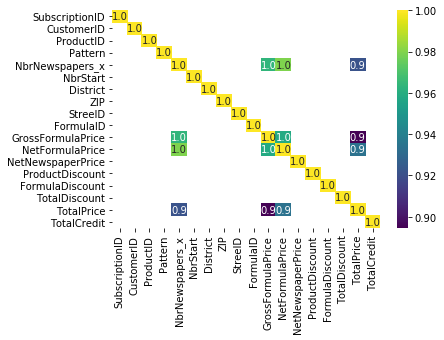

In [19]:
# Identifying columns with pearson correlation coefficient more than .8 

cols_corr = int_col + float_col
corrs = merged_df[cols_corr].corr()
sns.heatmap(corrs[corrs > 0.8],cmap='viridis', fmt=".1f",annot=True)

In [20]:
# Dropping columns 'NetFormulaPrice','TotalPrice','GrossFormulaPrice' due to high correlation with NbrNewspapers_x
merged_df = merged_df.drop(columns=['NetFormulaPrice','TotalPrice','GrossFormulaPrice'],axis=1)

In [21]:
# Datatypes , number of unique values and number of null values in each column
pd.concat([merged_df.dtypes,merged_df.nunique(),merged_df.isna().sum()],axis=1).sort_values(by=[1])

,0,1,2
PaymentType,object,2,0
Gender,object,2,1886
PaymentStatus,object,2,0
Churn,int32,2,0
DeliveryClass,object,2,9187
DeliveryType,object,3,0
District,int32,8,0
ProductID,int32,8,0
Pattern,int32,12,0
NbrStart,float64,13,117


In [22]:
# Identifying numeric , categorical and datetime variables
num_var = []
cat_var = []
date_var = []
for col in merged_df:
    col_type = str(merged_df[col].dtype)
    unique_count = merged_df[col].nunique()
    if unique_count < 13 :
        cat_var.append(col)
    elif 'int' in col_type or 'float' in col_type:
        num_var.append(col)
    else:
        date_var.append(col)
        
num_var
cat_var
date_var

['SubscriptionID',
 'CustomerID',
 'NbrNewspapers_x',
 'NbrStart',
 'FormulaID',
 'NetNewspaperPrice',
 'ProductDiscount',
 'FormulaDiscount',
 'TotalDiscount',
 'TotalCredit',
 'ZIP',
 'StreeID']

['DeliveryType',
 'DeliveryClass',
 'ProductID',
 'Pattern',
 'PaymentType',
 'PaymentStatus',
 'Gender',
 'District',
 'Churn']

['StartDate_x',
 'EndDate_x',
 'StartDate_y',
 'EndDate_y',
 'RenewalDate',
 'PaymentDate',
 'DOB']

## 2.3 Missing Value Treatment Numeric variables

In [23]:
# Filling missing values with mode where unique values are less and rest with median for numeric variables
merged_df.NbrStart = merged_df.NbrStart.fillna(merged_df.NbrStart.mode())
merged_df.ProductDiscount = merged_df.ProductDiscount.fillna(merged_df.ProductDiscount.mode())
merged_df.FormulaDiscount = merged_df.FormulaDiscount.fillna(merged_df.FormulaDiscount.mode())
merged_df.TotalDiscount = merged_df.TotalDiscount.fillna(merged_df.TotalDiscount.mode())
merged_df.TotalCredit = merged_df.TotalCredit.fillna(merged_df.TotalCredit.median())
merged_df.NetNewspaperPrice = merged_df.NetNewspaperPrice.fillna(merged_df.NetNewspaperPrice.median())


In [24]:
pd.concat([merged_df.dtypes,merged_df.nunique(),merged_df.isna().sum()],axis=1).sort_values(by=[1])

,0,1,2
PaymentType,object,2,0
Gender,object,2,1886
PaymentStatus,object,2,0
Churn,int32,2,0
DeliveryClass,object,2,9187
DeliveryType,object,3,0
District,int32,8,0
ProductID,int32,8,0
Pattern,int32,12,0
NbrStart,float64,13,117


In [25]:
# Summary for continuous variables
def cont_var_summary(col):
    return(pd.Series([col.count(),
                      col.isnull().sum(),
                      col.sum(),
                      col.mean(),
                      col.median(),
                      col.std(),
                      col.var(),
                      col.min(),
                      col.dropna().quantile(0.01),
                      col.dropna().quantile(0.05),
                      col.dropna().quantile(0.25),
                      col.dropna().quantile(0.50),
                      col.dropna().quantile(0.75),
                      col.dropna().quantile(0.95),
                      col.dropna().quantile(0.99),
                      col.max()], 
                  index=['N',
                         'NMISS',
                         'SUM',
                         'MEAN',
                         'MEDIAN',
                         'STD', 
                         'VAR',
                         'MIN', 
                         'P1' ,
                         'P5',
                         'P25' ,
                         'P50' ,
                         'P75' ,
                         'P95' ,
                         'P99' ,
                         'MAX']))

In [26]:
merged_df[num_var].apply(lambda x : cont_var_summary(x))

,SubscriptionID,CustomerID,NbrNewspapers_x,NbrStart,FormulaID,NetNewspaperPrice,ProductDiscount,FormulaDiscount,TotalDiscount,TotalCredit,ZIP,StreeID
N,6.234400e+04,6.234400e+04,6.234400e+04,62227.000000,6.234400e+04,62344.000000,62301.000000,59440.000000,59397.000000,62344.000000,6.234400e+04,6.234400e+04
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,117.000000,0.000000e+00,0.000000,43.000000,2904.000000,2947.000000,0.000000,0.000000e+00,0.000000e+00
SUM,3.967660e+10,3.196096e+10,1.305767e+07,909203.000000,1.578050e+12,50577.035630,61127.368076,230324.439000,291451.807076,-202910.747000,2.141502e+08,2.282341e+09
MEAN,6.364140e+05,5.126550e+05,2.094454e+02,14.611069,2.531198e+07,0.811257,0.981162,3.874906,4.906844,-3.254696,3.434977e+03,3.660882e+04
MEDIAN,6.010370e+05,6.486740e+05,3.040000e+02,10.000000,4.242000e+03,0.819079,0.000000,0.000000,0.000000,0.000000,3.454000e+03,3.734300e+04
STD,3.486594e+05,3.277738e+05,1.189960e+02,7.001670,4.347748e+07,0.165078,15.482811,20.084980,25.438051,14.231888,1.514414e+03,2.173582e+04
VAR,1.215634e+11,1.074356e+11,1.416005e+04,49.023384,1.890291e+15,0.027251,239.717432,403.406409,647.094459,202.546623,2.293450e+06,4.724460e+08
MIN,5.382000e+04,3.407000e+03,2.000000e+00,0.000000,2.300000e+01,0.000000,0.000000,0.000000,0.000000,-974.704000,1.070000e+03,0.000000e+00
P1,6.847743e+04,7.182000e+03,1.200000e+01,1.000000,2.900000e+02,0.000000,0.000000,0.000000,0.000000,-42.400000,1.820000e+03,0.000000e+00
P5,1.356411e+05,4.402600e+04,2.500000e+01,10.000000,8.690000e+02,0.560000,0.000000,0.000000,0.000000,-21.530000,2.070000e+03,1.246000e+04


## 2.4 Outlier capping Numeric variables

In [27]:
def cont_outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

In [28]:
merged_df[num_var] = merged_df[num_var].apply(lambda x : cont_outlier_capping(x))

## 2.5 Label encoding and one-hot encoding categorical variables

- Using label encoding where there are two categories
- Using one-hot encoding where number of categories are more than two

In [29]:
# Summary for categorical variables
def cat_var_summary(col):
    return pd.Series([col.count(), col.isnull().sum(), col.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

In [30]:
# increasing column width 
pd.options.display.max_colwidth = 10000

In [31]:
merged_df[cat_var].apply(lambda x : cat_var_summary(x)).T

,N,NMISS,ColumnsNames
DeliveryType,62344,0,"MD 49391 DI 9825 DR 3128 Name: DeliveryType, dtype: int64"
DeliveryClass,53157,9187,"NOR 50907 ABN 2250 Name: DeliveryClass, dtype: int64"
ProductID,62344,0,"8 28475 7 6348 2 6270 4 5893 6 5303 5 4360 3 3793 1 1902 Name: ProductID, dtype: int64"
Pattern,62344,0,"1111110 60547 10 1130 1000000 343 100 179 1010000 36 110 35 1000010 23 10000 21 1010010 18 100010 6 10010 3 1100010 3 Name: Pattern, dtype: int64"
PaymentType,62344,0,"BT 55752 DD 6592 Name: PaymentType, dtype: int64"
PaymentStatus,62344,0,"Paid 61105 Not Paid 1239 Name: PaymentStatus, dtype: int64"
Gender,60458,1886,"M 48936 F 11522 Name: Gender, dtype: int64"
District,62344,0,"1 28089 5 25993 7 3168 2 3078 4 1525 8 307 3 96 6 88 Name: District, dtype: int64"
Churn,62344,0,"0 43992 1 18352 Name: Churn, dtype: int64"


In [32]:

lc=LabelEncoder()
merged_df['Gender']=lc.fit_transform(merged_df['Gender'])
merged_df['PaymentStatus']=lc.fit_transform(merged_df['PaymentStatus'])
merged_df['PaymentType']=lc.fit_transform(merged_df['PaymentType'])
merged_df['DeliveryClass']=lc.fit_transform(merged_df['DeliveryClass'])

In [33]:
#DeliveryType
col=pd.get_dummies(merged_df['DeliveryType'],prefix='DeliveryType')
col=col.drop(col.columns[0],axis=1)
merged_df=pd.concat([merged_df,col],axis=1)
merged_df=merged_df.drop('DeliveryType',axis=1)

#District
col=pd.get_dummies(merged_df['District'],prefix='District')
col=col.drop(col.columns[0],axis=1)
merged_df=pd.concat([merged_df,col],axis=1)
merged_df=merged_df.drop('District',axis=1)

In [34]:
# dropping rows containing null values or duplicates
merged_df=merged_df.dropna()
merged_df.reset_index(drop=True,inplace=True)
merged_df=merged_df.drop_duplicates()
merged_df=merged_df.reset_index(drop=True)

## 2.6 Converting Datetime variables to ordinal 

In [35]:
#Converting Timestamp to ordinal
for col in date_var:
    merged_df[col] = merged_df[col].apply(lambda x: x.toordinal())

# 3. Building Models

## 3.1 Splitting Target and Dependent variables

In [36]:
y = merged_df['Churn']
merged_df.drop('Churn',axis=1,inplace=True)

## 3.2 Scaling data for different models

In [37]:
X = merged_df.astype(np.float)
scaler = StandardScaler()
X = scaler.fit_transform(X)
print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)


Feature space holds 24871 observations and 34 features
Unique target labels: [0 1]


## 3.3 Models Used

- KFold cross validation 
    - It is not the model but used to get the better model
    - To estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model
<br><br>   
- Suuport Vector Machines
    - It is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.
<br><br> 
- Random Forest Classifier
    - It creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.
<br><br> 
- Logistic Regression
    - Logistic regression models the probability of the default class of dependent variable
<br><br>     
- Gradient Boost Classifier
    - It repetitively leverage the patterns in residuals and strengthen a model with weak predictions and make it better. Once we reach a stage that residuals do not have any pattern that could be modeled, we can stop modeling residuals (otherwise it might lead to overfitting). Algorithmically, we are minimizing our loss function, such that test loss reach its minima

In [41]:
# Applying different models and storing metrics in scores dataframe

# Applies classsifier after cross validation and returns predicted y
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(shuffle=True,random_state=0).split(y)
    y_pred = y.copy()
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

# Evaluates different metrics based on target variable and predicted values
def get_scores(X,y,classifiers,**kwargs):
    scores = pd.DataFrame()
    
    for name,classifier in classifiers.items():
        y_pred = run_cv(X,y,classifier,**kwargs)
        col = pd.Series()
        
        col['Confusion matrix'] = confusion_matrix(y,y_pred)
        col['Accuracy score'] =accuracy_score(y,y_pred)
        col['F1 score'] = f1_score(y,y_pred,average='binary')
        col['ROC AUC Score'] = roc_auc_score(y,y_pred)
        col['Average Precision score'] = average_precision_score(y,y_pred)
        col['Recall Score'] = recall_score(y,y_pred)
        
        scores[name] =  col
    return(scores)

In [42]:
classifiers = {'Support Vector Machines':SVC,\
              'Random Forest Classifier':RFC,\
              'K Neighbors Classifier':KNC,\
              'Logistic Regression':LR,\
              'Gradient Boosting Classifier':GBC}

scores = get_scores(X,y,classifiers)
scores = scores.T

C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 t

**Evaluation Metrics :**
- Accuracy Score
    - Accuracy = TP+TN/TP+FP+FN+TN
<br><br>
- F1 Score
    - F1 Score = 2*(Recall * Precision) / (Recall + Precision)
<br><br>
- ROC AUC Score
    - The Receiver Operating Characteristic (ROC) curve is a plot of the true positive rate (% bads rejected) vs. the false positive rate (% goods rejected) found over a set of predictions.
    - TPR = TP/(TP + FN) 
    - FPR = FP/(FP + TN)
    - (ROC AUC) is just the area under the ROC curve. The higher it is, the better the model is.
<br><br>
- Average Precision Score
    - Precision = TP/TP+FP
<br><br>
- Recall Score
    - Recall = TP/TP+FN

In [43]:
scores.sort_values(by=scores.columns.tolist()[1:],ascending=[False for item in scores.columns][1:])

,Confusion matrix,Accuracy score,F1 score,ROC AUC Score,Average Precision score,Recall Score
Random Forest Classifier,"[[17643, 89], [231, 6908]]",0.987134,0.977363,0.981312,0.964622,0.967643
Gradient Boosting Classifier,"[[17615, 117], [322, 6817]]",0.982349,0.968806,0.974149,0.95173,0.954896
Support Vector Machines,"[[17612, 120], [436, 6703]]",0.977645,0.960178,0.96608,0.939944,0.938927
K Neighbors Classifier,"[[17517, 215], [357, 6782]]",0.977001,0.959536,0.968934,0.935156,0.949993
Logistic Regression,"[[17588, 144], [486, 6653]]",0.974669,0.954793,0.961901,0.931721,0.931923


_Random Forest Classifier has got the best accuracy score, F1 score , ROC AUC Score , Precision Score and Recall Score_

Text(0.5,1,'Confusion matrix for Random Forest Classifier')

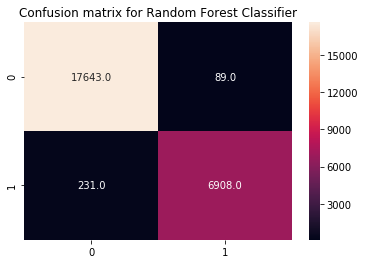

In [44]:
plt.title('Confusion matrix for Random Forest Classifier')
sns.heatmap(scores.loc['Random Forest Classifier','Confusion matrix'], fmt=".1f",annot=True)

**Random Forest Classifier is the final Model**